# Krakow Transport Network Analysis
## Combining GTFS and OSM Data to Identify Critical Infrastructure

---

### Overview
This notebook analyzes Krakow's transport network by combining:
- **GTFS data**: Public transport schedules and routes
- **OSM data**: Street network infrastructure

We'll identify critical nodes using graph centrality metrics and visualize the integrated network.

In [190]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import networkx as nx
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import folium
from folium.plugins import MarkerCluster
from folium import Popup
from shapely.geometry import Point, LineString
from scipy.spatial import cKDTree
from matplotlib.colors import TwoSlopeNorm
import plotly.graph_objects as go
import zipfile
import html
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from itertools import combinations



# Configure OSMnx
ox.settings.log_console = True
ox.settings.use_cache = True
ox.settings.timeout = 600

# Check if the GTFS data directory exists, if not, extract from zip
if not os.path.exists('gtfs'):
    if os.path.exists('gtfs.zip'):
        with zipfile.ZipFile('gtfs.zip', 'r') as zip_ref:
            zip_ref.extractall('gtfs')
        print("Extracted gtfs.zip to gtfs/")
    else:
        print("gtfs.zip not found. Please provide the GTFS data.")

# Set the directory for saving analysis results
RESULTS_DIR = 'results'
GTFS_KRK_A = "gtfs/GTFS_KRK_A"

GTFS_DIR = os.path.join(RESULTS_DIR, 'gtfs_graph')
OSM_DIR = os.path.join(RESULTS_DIR, 'osm_graph')
MERGED_DIR = os.path.join(RESULTS_DIR, 'merged_gtfs_osm')

# Create directories if they do not exist
if not os.path.exists(GTFS_DIR):
    os.makedirs(GTFS_DIR)
if not os.path.exists(OSM_DIR):
    os.makedirs(OSM_DIR)
if not os.path.exists(MERGED_DIR):
    os.makedirs(MERGED_DIR)

## 1. Load and Prepare GTFS Data

In [3]:
def load_gtfs(data_dir=GTFS_KRK_A):
    """Load and preprocess GTFS datasets"""
    files = {
        'shapes': 'shapes.txt',
        'stops': 'stops.txt',
        'trips': 'trips.txt',
        'routes': 'routes.txt',
        'stop_times': 'stop_times.txt',
        'calendar': 'calendar.txt',
        'calendar_dates': 'calendar_dates.txt'
    }
    
    dfs = {}
    for name, file in files.items():
        try:
            dfs[name] = pd.read_csv(f'{data_dir}/{file}')
            print(f"Loaded {file}: {dfs[name].shape[0]} rows")
        except FileNotFoundError:
            print(f"Warning: {file} not found")
    return dfs

# Load data
gtfs = load_gtfs()

Loaded shapes.txt: 834851 rows
Loaded stops.txt: 3010 rows
Loaded trips.txt: 40368 rows
Loaded routes.txt: 167 rows
Loaded stop_times.txt: 882311 rows
Loaded calendar.txt: 5 rows
Loaded calendar_dates.txt: 8 rows


## 2. Analyze Transit Operations

In [191]:
def analyze_transit_operations(trips_df):
    """Analyze number of trips per route and direction"""
    # Count trips per route and direction
    counts = trips_df.groupby(['route_id', 'direction_id'])['trip_id'].count().reset_index()
    counts['route_direction'] = counts['route_id'].astype(str) + ' - ' + counts['direction_id'].astype(str)
    
    # Create interactive bar chart
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=counts['trip_id'], 
        y=counts['route_direction'], 
        orientation='h', 
        text=counts['trip_id'],
        textposition='outside'
    ))
    
    fig.update_layout(
        title='Number of Trips per Route and Direction',
        xaxis_title='Number of Trips',
        yaxis_title='Route - Direction',
        yaxis={'categoryorder': 'total ascending'},
        height=800
    )
    fig.write_html(os.path.join(GTFS_DIR, '2_trips_per_route_direction.html'))
    fig.show()
    return counts

# Analyze transit operations
trip_counts = analyze_transit_operations(gtfs['trips'])

In [ ]:
# Print the busiest route-direction
busiest = trip_counts.sort_values('trip_id', ascending=False).iloc[:5]
print("Top-5 busiest route-direction:")
print(busiest)

Top-5 busiest route-direction:
      route_id  direction_id  trip_id route_direction
215  route_606             0      459   route_606 - 0
216  route_606             1      457   route_606 - 1
129   route_23             0      432    route_23 - 0
130   route_23             1      427    route_23 - 1
49   route_126             1      387   route_126 - 1


## 3. Preprocess Route Shapes

In [5]:
def preprocess_shapes(shapes_df):
    """Convert shape points into segments"""
    # Create segments between consecutive shape points
    coords = shapes_df[["shape_pt_lat", "shape_pt_lon", "shape_pt_sequence"]]
    coords_roll_1 = np.roll(coords, 1, axis=0)
    
    segments = pd.DataFrame(
        np.concatenate([coords_roll_1, coords], axis=1),
        columns=["start_lat", "start_lng", "start_seq", "end_lat", "end_lng", "end_seq"]
    )
    
    segments_df = shapes_df[["shape_id"]].join(segments)
    segments_df = segments_df[segments_df.end_seq != 1]  # Remove artificial segments
    segments_df = segments_df.drop(columns=['end_seq']).rename(columns={"start_seq": "seq"})
    
    return segments_df

# Preprocess shapes
segments_df = preprocess_shapes(gtfs['shapes'])

In [55]:
gtfs['shapes']

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,shape_6254,50.088569,19.931231,1,NaN
1,shape_6254,50.084464,19.930583,2,NaN
2,shape_6254,50.084464,19.930583,3,NaN
3,shape_6254,50.084011,19.927692,4,NaN
4,shape_6254,50.084011,19.927692,5,NaN
...,...,...,...,...,...
834846,shape_6626,50.017732,19.890164,248,NaN
834847,shape_6626,50.017659,19.889795,249,NaN
834848,shape_6626,50.017641,19.889712,250,NaN
834849,shape_6626,50.017590,19.889506,251,NaN


In [54]:
segments_df

,shape_id,start_lat,start_lng,seq,end_lat,end_lng
1,shape_6254,50.088569,19.931231,1.0,50.084464,19.930583
2,shape_6254,50.084464,19.930583,2.0,50.084464,19.930583
3,shape_6254,50.084464,19.930583,3.0,50.084011,19.927692
4,shape_6254,50.084011,19.927692,4.0,50.084011,19.927692
5,shape_6254,50.084011,19.927692,5.0,50.081518,19.916122
...,...,...,...,...,...,...
834846,shape_6626,50.017770,19.890385,247.0,50.017732,19.890164
834847,shape_6626,50.017732,19.890164,248.0,50.017659,19.889795
834848,shape_6626,50.017659,19.889795,249.0,50.017641,19.889712
834849,shape_6626,50.017641,19.889712,250.0,50.017590,19.889506


## 4. Calculate Segment Utilization

- **shape_per_day**: Counts the number of trips per shape (route pattern).
- **segment_per_day**: Merges this count onto every segment belonging to that shape, so every segment in a shape gets the total trip count for that shape.
- **segment_day_trips**: Groups by segment coordinates and sums the trip counts.

If a segment appears in multiple shapes, its trip counts are summed across all shapes it appears in.


In [192]:
def calculate_segment_utilization(trips_df, segments_df):
    """Calculate daily trip frequency per segment and plot interactive histogram"""
    # Count trips per shape (all directions)
    shape_per_day = trips_df.groupby(['shape_id'])['trip_id'].count().reset_index()

    # Merge with segments
    segment_per_day = pd.merge(segments_df, shape_per_day, on="shape_id")
    
    # Aggregate by segment
    segment_day_trips = segment_per_day.groupby(
        by=["start_lat", "start_lng", "end_lat", "end_lng"]
    ).sum("trip_id").reset_index()
    
    # Create interactive histogram with Plotly
    import plotly.express as px
    fig = px.histogram(
        segment_day_trips,
        x='trip_id',
        nbins=50,
        title='Distribution of Daily Trip Frequencies per Segment',
        labels={'trip_id': 'Number of Daily Trips'},
        opacity=0.8
    )
    fig.update_layout(
        xaxis_title='Number of Daily Trips',
        yaxis_title='Segment Count',
        bargap=0.1,
        height=500
    )
    html_path = os.path.join(GTFS_DIR, '4_5_segment_trip_distribution_interactive.html')
    fig.write_html(html_path)
    fig.show()
    return segment_day_trips

# Calculate segment utilization
segment_day_trips = calculate_segment_utilization(gtfs['trips'], segments_df)
# Print summary statistics
print(segment_day_trips.describe())


          start_lat     start_lng       end_lat       end_lng           seq  \
count  86460.000000  86460.000000  86460.000000  86460.000000  86460.000000   
mean      50.055041     19.920093     50.055042     19.920089   1323.638735   
std        0.068946      0.129525      0.068948      0.129537   1616.901858   
min       49.899553     19.583692     49.899553     19.583692      1.000000   
25%       50.000788     19.820662     50.000772     19.820658    384.000000   
50%       50.057853     19.926372     50.057853     19.926371    826.000000   
75%       50.103655     20.003893     50.103659     20.003893   1684.000000   
max       50.245430     20.352689     50.245430     20.352689  22899.000000   

            trip_id  
count  86460.000000  
mean     266.752024  
std      369.184366  
min        1.000000  
25%       78.000000  
50%      141.000000  
75%      296.000000  
max     4684.000000  


### 4.6 Visualization Top 20 busiest segments (red) and 20 least used segments (blue)

In [193]:
def visualize_segment_usage(segment_day_trips, filename='4_6_segment_usage_top20_bottom20.html'):
    """
    Visualize the top 20 busiest segments (red) and 20 least used segments (blue) on a Folium map.
    """
    # Get top 20 busiest and 20 least used segments
    top20 = segment_day_trips.sort_values('trip_id', ascending=False).head(20)
    bottom20 = segment_day_trips.sort_values('trip_id', ascending=True).head(20)

    # Center map on the mean of all segment start points
    center_lat = segment_day_trips['start_lat'].mean()
    center_lng = segment_day_trips['start_lng'].mean()
    m = folium.Map(location=[center_lat, center_lng], zoom_start=12, tiles='CartoDB positron')

    # Plot top 20 busiest segments in red
    for _, row in top20.iterrows():
        folium.PolyLine(
            locations=[[row['start_lat'], row['start_lng']], [row['end_lat'], row['end_lng']]],
            color='red',
            weight=6,
            popup=f"Busiest: {row['trip_id']} trips/day"
        ).add_to(m)

    # Plot 20 least used segments in blue
    for _, row in bottom20.iterrows():
        folium.PolyLine(
            locations=[[row['start_lat'], row['start_lng']], [row['end_lat'], row['end_lng']]],
            color='blue',
            weight=4,
            popup=f"Least used: {row['trip_id']} trips/day"
        ).add_to(m)

    # Save map
    full_path = os.path.join(GTFS_DIR, filename)
    m.save(full_path)
    print(f"Segment usage map saved as {full_path}")

# Example usage:
visualize_segment_usage(segment_day_trips)

# Print the 20 busiest segments
print("Top 20 busiest segments:")
print(segment_day_trips.sort_values('trip_id', ascending=False).head(20))

# Print the 20 least used segments
print("20 least used segments:")
print(segment_day_trips.sort_values('trip_id', ascending=True).head(20))

Segment usage map saved as results/gtfs_graph/4_6_segment_usage_top20_bottom20.html
Top 20 busiest segments:
       start_lat  start_lng    end_lat    end_lng      seq  trip_id
43442  50.058296  19.925542  50.058249  19.925578  10400.0     4684
43406  50.058249  19.925578  50.058153  19.925644  10428.0     4684
43630  50.058627  19.925311  50.058296  19.925542  10372.0     4684
43672  50.058725  19.925242  50.058627  19.925311  10344.0     4684
43677  50.058741  19.925231  50.058725  19.925242   9284.0     4642
43927  50.059301  19.924849  50.059164  19.924932  10016.0     4424
43678  50.058741  19.925231  50.058741  19.925231   9035.0     4382
43858  50.059164  19.924932  50.058741  19.925231   9011.0     4382
44136  50.059522  19.925193  50.059758  19.925053   9549.0     4218
43959  50.059359  19.925291  50.059444  19.925240   9477.0     4218
44741  50.060673  19.924513  50.060843  19.924419   9643.0     4218
44783  50.060843  19.924419  50.060953  19.924363   9667.0     4218
44096  

### 4.7 Comprehensive analysis of the busiest segment

In [90]:
busiest_segment = segment_day_trips.sort_values('trip_id', ascending=False).head(1)
print("Busiest segment:")
print(busiest_segment)
# Find all rows in segments_df that match the busiest segment's coordinates
busiest_row = busiest_segment.iloc[0]
print("Busiest segment coordinates:")
mask = (
    (segments_df['start_lat'] == busiest_row['start_lat']) &
    (segments_df['start_lng'] == busiest_row['start_lng']) &
    (segments_df['end_lat'] == busiest_row['end_lat']) &
    (segments_df['end_lng'] == busiest_row['end_lng'])
)
matching_segments = segments_df[mask]
print(matching_segments)

# Get all shape_ids for this segment
shape_ids = matching_segments['shape_id'].unique()

# Find all trips that use these shapes
trips_using_segment = gtfs['trips'][gtfs['trips']['shape_id'].isin(shape_ids)]
print(trips_using_segment[['trip_id', 'route_id', 'direction_id', 'shape_id']])

Busiest segment:
       start_lat  start_lng    end_lat    end_lng      seq  trip_id
43442  50.058296  19.925542  50.058249  19.925578  10400.0     4684
Busiest segment coordinates:
          shape_id  start_lat  start_lng    seq    end_lat    end_lng
1621    shape_6267  50.058296  19.925542  224.0  50.058249  19.925578
2068    shape_6273  50.058296  19.925542  224.0  50.058249  19.925578
25888   shape_2919  50.058296  19.925542  316.0  50.058249  19.925578
38683   shape_6432  50.058296  19.925542  271.0  50.058249  19.925578
41808   shape_6916  50.058296  19.925542  271.0  50.058249  19.925578
...            ...        ...        ...    ...        ...        ...
725279  shape_6742  50.058296  19.925542  174.0  50.058249  19.925578
726565  shape_6746  50.058296  19.925542  162.0  50.058249  19.925578
733104  shape_3305  50.058296  19.925542  245.0  50.058249  19.925578
733730  shape_3306  50.058296  19.925542  224.0  50.058249  19.925578
736036  shape_6783  50.058296  19.925542  224.0 

In [194]:
busiest_segment = segment_day_trips.sort_values('trip_id', ascending=False).head(1)
row = busiest_segment.iloc[0]
center = [(row['start_lat'] + row['end_lat']) / 2, (row['start_lng'] + row['end_lng']) / 2]
m = folium.Map(location=center, zoom_start=16, tiles='CartoDB positron')

folium.PolyLine(
    locations=[[row['start_lat'], row['start_lng']], [row['end_lat'], row['end_lng']]],
    color='red',
    weight=8,
    popup=f"Busiest segment: {row['trip_id']} trips/day"
).add_to(m)
m.save(os.path.join(GTFS_DIR, '4_7_single_busiest_segment_map.html'))

In [87]:
print(trips_using_segment['route_id'].unique())

['route_602' 'route_580' 'route_596' 'route_599' 'route_199' 'route_125'
 'route_126' 'route_130' 'route_18' 'route_606' 'route_135' 'route_136'
 'route_477' 'route_482' 'route_612' 'route_61' 'route_139' 'route_587'
 'route_166' 'route_141' 'route_359' 'route_165' 'route_162' 'route_143']


Those values like 'route_602', 'route_580', etc., are route IDs from your GTFS data, but they are not always the same as the public-facing bus line numbers.

In GTFS, the route_id is often an internal identifier. The actual bus line number is usually found in the route_short_name column of the routes.txt file.

To get the real bus line numbers for your segment, you should join your route_id values with the routes DataFrame and look at route_short_name.

In [89]:
# Get the routes DataFrame
routes = gtfs['routes']

# Get unique route_ids for the segment
route_ids = sorted(trips_using_segment['route_id'].unique())

# Find the corresponding public bus numbers (route_short_name)
bus_lines = routes[routes['route_id'].isin(route_ids)][['route_id', 'route_short_name']]
print(bus_lines)

      route_id  route_short_name
7     route_18               124
17    route_61               307
71   route_125               301
72   route_126               304
76   route_130               424
78   route_135               502
79   route_136               503
82   route_139               601
84   route_141               608
86   route_143               611
95   route_162               609
98   route_165               300
99   route_166               310
103  route_199               469
110  route_359               700
116  route_477               513
118  route_482               494
125  route_580               134
128  route_587               144
133  route_596               164
135  route_599               169
138  route_602               173
141  route_606               179
143  route_612               194


In [99]:
route_short_name = [124,307, 301, 304, 424, 502, 503, 601, 608, 611, 609, 300, 310, 469, 700, 513, 494, 134, 144, 164, 169, 173, 179, 194]
buses_2 = [109, 124, 134, 144,164,169,173,179,194,300, 301,304,307,310,424,469, 494, 502, 503, 513, 608, 609, 610, 990]
buses = list(set((buses_2)))  
print(buses)
buses_not_in_busiest = [bus for bus in buses if bus not in route_short_name]
print("Buses not in the busiest segment:", buses_not_in_busiest)


[513, 134, 144, 164, 424, 169, 300, 173, 301, 304, 179, 307, 310, 194, 469, 990, 608, 609, 610, 109, 494, 502, 503, 124]
Buses not in the busiest segment: [990, 610, 109]


route_id is often an internal code.
route_short_name is usually the bus/tram line number you see on the map or vehicle.

## 5. Build Stop Network Graph

Let's prepare the visualization function for the graph

In [195]:
def visualize_stop_network(G, stops_df, filename='5_gtfs_network_graph.html', max_edges=100000):
    """Visualize the stop network (nodes and edges) as an interactive Folium map."""

    # Get node positions
    stop_positions = stops_df.set_index('stop_id')[['stop_lat', 'stop_lon']].to_dict('index')
    # Center map on Krakow's main square instead of mean
    center_lat = 50.0614
    center_lon = 19.9372
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles='CartoDB positron')

    # Draw edges (limit for performance)
    for i, (u, v, data) in enumerate(G.edges(data=True)):
        if i > max_edges:
            break
        if u in stop_positions and v in stop_positions:
            folium.PolyLine(
                locations=[
                    [stop_positions[u]['stop_lat'], stop_positions[u]['stop_lon']],
                    [stop_positions[v]['stop_lat'], stop_positions[v]['stop_lon']]
                ],
                color='red', weight=2, opacity=0.5
            ).add_to(m)

    # Draw nodes
    for stop_id, pos in stop_positions.items():
        folium.CircleMarker(
            location=[pos['stop_lat'], pos['stop_lon']],
            radius=3, color='black', fill=True, fill_opacity=0.7
        ).add_to(m)

    full_path = os.path.join(GTFS_DIR, filename)
    m.save(full_path)
    print(f"Network map saved as {full_path}")

In [196]:
def build_stop_network(stop_times_df, trips_df, stops_df):
    """Create directed graph of stops"""
    # Merge stop_times with trips to get direction information
    stop_times_with_direction = pd.merge(
        stop_times_df, 
        trips_df[['trip_id', 'direction_id']], 
        on='trip_id'
    )
    
    # Filter for direction_id = 1 and sort stops
    # direction_1_stop_times = stop_times_with_direction[
    #     stop_times_with_direction['direction_id'] == 1
    # ].sort_values(['trip_id', 'stop_sequence'])

    # No filtering by direction_id, as we want to analyze all directions
    direction_1_stop_times = stop_times_with_direction.sort_values(['trip_id', 'stop_sequence'])
    
    # Create edges between consecutive stops
    direction_1_stop_times['to_stop'] = direction_1_stop_times.groupby('trip_id')['stop_id'].shift(-1)
    edges_df = direction_1_stop_times.dropna(subset=['to_stop'])[['stop_id', 'to_stop']]
    edges_df.columns = ['from_stop', 'to_stop']
    
    # Calculate edge weights
    edge_weights = edges_df.groupby(['from_stop', 'to_stop']).size().reset_index(name='weight')
    
    # Create directed graph
    G = nx.DiGraph()
    for _, row in edge_weights.iterrows():
        G.add_edge(row['from_stop'], row['to_stop'], weight=row['weight'])
    visualize_stop_network(G, gtfs['stops'])
    # Calculate centrality measures
    print("Calculating eigenvector centrality...")
    eigen_centrality = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)
    
    print("Calculating PageRank...")
    pagerank = nx.pagerank(G, weight='weight')
    
    print("Calculating betweenness centrality...")
    betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
    
    print("Calculating degree centrality...")
    degree_centrality = nx.degree_centrality(G)
    
    # Create DataFrames
    centrality_dfs = {}
    for name, centrality in [('eigen', eigen_centrality), 
                            ('pagerank', pagerank),
                            ('betweenness', betweenness_centrality),
                            ('degree', degree_centrality)]:
        df = pd.DataFrame.from_dict(centrality, orient='index', columns=[name]).reset_index()
        df.columns = ['stop_id', name]
        df = pd.merge(df, stops_df[['stop_id', 'stop_name', 'stop_lat', 'stop_lon']], on='stop_id')
        centrality_dfs[name] = df
    
    return centrality_dfs

# Build stop network
centrality_dfs = build_stop_network(gtfs['stop_times'], gtfs['trips'], gtfs['stops'])

Network map saved as results/gtfs_graph/5_gtfs_network_graph.html
Calculating eigenvector centrality...
Calculating PageRank...
Calculating betweenness centrality...
Calculating degree centrality...


In [109]:

# Display top central stops
print("Top Eigenvector Centrality Stops:")
print(centrality_dfs['eigen'].sort_values('eigen', ascending=False).head(5))

print("\nTop PageRank Stops:")
print(centrality_dfs['pagerank'].sort_values('pagerank', ascending=False).head(5))

print("\nTop Betweenness Centrality Stops:")
print(centrality_dfs['betweenness'].sort_values('betweenness', ascending=False).head(5))

print("\nTop Degree Centrality Stops:")
print(centrality_dfs['degree'].sort_values('degree', ascending=False).head(5))

Top Eigenvector Centrality Stops:
               stop_id     eigen             stop_name   stop_lat   stop_lon
2499    stop_439_62001  0.385692          Kamieńskiego  50.028884  19.956902
585     stop_432_61003  0.375085      Rondo Matecznego  50.035877  19.941375
1623  stop_2108_333803  0.292769    Rondo Grunwaldzkie  50.048252  19.932344
1260    stop_438_61901  0.263357  Kamieńskiego Wiadukt  50.031107  19.949137
584   stop_1200_280801  0.254721              Ludwinów  50.043236  19.934745

Top PageRank Stops:
               stop_id  pagerank            stop_name   stop_lat   stop_lon
11    stop_1654_314104  0.002035      Muzeum Narodowe  50.058644  19.925202
1791   stop_984_247501  0.001730     Skawina Cmentarz  49.975187  19.831138
557        stop_7_1203  0.001718  Rondo Ofiar Katynia  50.086632  19.891059
1200    stop_237_31904  0.001513              Jubilat  50.056091  19.926715
1826  stop_2309_345907  0.001508        Bronowice SKA  50.081535  19.890548

Top Betweenness Centrality

#### Visualize Central Stops

In [197]:
def visualize_central_stops(centrality_df, centrality_type, title):
    """Create interactive map of stops with centrality"""
    # Normalize centrality for visualization
    centrality_df['normalized'] = centrality_df[centrality_type] / centrality_df[centrality_type].max()
    
    # Create map with a lighter background
    center_lat = centrality_df['stop_lat'].mean()
    center_lon = centrality_df['stop_lon'].mean()
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles='CartoDB positron')
    
    # Add stops
    for idx, row in centrality_df.iterrows():
        radius = 5 + (row['normalized'] * 30)
        color = f'#{int(255 * row["normalized"]):02x}0000'
        
        folium.CircleMarker(
            location=[row['stop_lat'], row['stop_lon']],
            radius=radius,
            color=color,
            fill=True,
            fill_opacity=0.7,
            popup=f"{row['stop_name']}<br>{centrality_type}: {row[centrality_type]:.4f}"
        ).add_to(m)
    
    # Add title
    title_html = f'''
        <h3 align="center" style="font-size:16px"><b>{title}</b></h3>
        '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    return m

# Visualize different centrality measures
eigen_map = visualize_central_stops(
    centrality_dfs['eigen'], 
    'eigen', 
    'Eigenvector Centrality - Influence in Well-connected Clusters'
)

eigen_map.save(os.path.join(GTFS_DIR,'5_1_eigen_centrality.html'))

pagerank_map = visualize_central_stops(
    centrality_dfs['pagerank'], 
    'pagerank', 
    'PageRank - High-traffic Transit Points'
)
pagerank_map.save(os.path.join(GTFS_DIR,'5_2_pagerank.html'))


betweenness_map = visualize_central_stops(
    centrality_dfs['betweenness'], 
    'betweenness', 
    'Betweenness Centrality - Key Transfer Points'
)
betweenness_map.save(os.path.join(GTFS_DIR,'5_3_betweenness_centrality.html'))

degree_map = visualize_central_stops(
    centrality_dfs['degree'], 
    'degree', 
    'Degree Centrality - Most Connected Stops'
)
degree_map.save(os.path.join(GTFS_DIR,'5_4_degree_centrality.html'))

## 6. Integrate OSM Street Data

In [17]:
def integrate_osm_data(place="Kraków, Poland"):
    """Download and prepare OSM street data"""
    print(f"Downloading OSM data for {place}...")
    # Get the street network
    G = ox.graph_from_place(place, network_type='drive', simplify=True)
    
    # Convert to GeoDataFrames
    nodes, edges = ox.graph_to_gdfs(G)
    
    print(f"OSM data downloaded: {len(nodes)} nodes, {len(edges)} edges")
    return G, nodes, edges

# Integrate OSM data
krk_streets, osm_nodes, osm_edges = integrate_osm_data()

OSM data downloaded: 9620 nodes, 21168 edges


In [199]:
def visualize_osm_streets(osm_nodes, osm_edges, filename='6_krakow_osm_streets_graph.html'):
    """Visualize OSM street network as an interactive Folium map."""
    import folium

    center_lat = osm_nodes['y'].mean()
    center_lon = osm_nodes['x'].mean()
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles='CartoDB positron')
    for node_id, row in osm_nodes.iterrows():
        folium.CircleMarker(
            location=[row['y'], row['x']],
            radius=2,
            color='black',
            fill=True,
            fill_opacity=0.7
        ).add_to(m)

    for _, row in osm_edges.iterrows():
        if row['geometry'].geom_type == 'LineString':
            folium.PolyLine(
                locations=[(lat, lon) for lon, lat in row['geometry'].coords],
                color='blue', weight=2, opacity=0.5
            ).add_to(m)
        elif row['geometry'].geom_type == 'MultiLineString':
            for linestring in row['geometry']:
                folium.PolyLine(
                    locations=[(lat, lon) for lon, lat in linestring.coords],
                    color='blue', weight=2, opacity=0.5
                ).add_to(m)

    full_path = os.path.join(OSM_DIR, filename)
    m.save(full_path)
    print(f"OSM street network map saved as {full_path}")

visualize_osm_streets(osm_nodes, osm_edges)


OSM street network map saved as results/osm_graph/6_krakow_osm_streets_graph.html


## 7. Multimodal Network: GTFS + OSM

In [40]:
def create_multimodal_network(krk_streets, segment_day_trips, merge_close_nodes=False, distance_threshold=0.0002):
    """Combine OSM street network with GTFS bus segments, with optional merging of close nodes"""
    integrated = nx.DiGraph()
    
    # Add OSM nodes
    for node, data in krk_streets.nodes(data=True):
        integrated.add_node(f'[ROAD]{node}', **data)
    
    # Add OSM edges
    for u, v, data in krk_streets.edges(data=True):
        if 'geometry' in data:
            geometry = data['geometry']
        else:
            start = Point(krk_streets.nodes[u]['x'], krk_streets.nodes[u]['y'])
            end = Point(krk_streets.nodes[v]['x'], krk_streets.nodes[v]['y'])
            geometry = LineString([start, end])
        highway = data.get('highway', 'unknown')
        if isinstance(highway, list):
            highway = highway[0]
        integrated.add_edge(
            f'[ROAD]{u}', 
            f'[ROAD]{v}', 
            road_size=highway, 
            geometry=geometry, 
            length=data.get('length', 0),
            type='road'
        )
    
    # Add GTFS bus segments
    for _, row in segment_day_trips.iterrows():
        start_node = f'[BUS]{row.start_lng},{row.start_lat}'
        end_node = f'[BUS]{row.end_lng},{row.end_lat}'
        start = Point(row.start_lng, row.start_lat)
        end = Point(row.end_lng, row.end_lat)
        geometry = LineString([start, end])
        integrated.add_node(start_node, x=row.start_lng, y=row.start_lat)
        integrated.add_node(end_node, x=row.end_lng, y=row.end_lat)
        integrated.add_edge(
            start_node, 
            end_node, 
            road_size='bus', 
            geometry=geometry, 
            type='bus', 
            arrivals=row['trip_id']
        )
    
    print(f"Integrated network created: {integrated.number_of_nodes()} nodes, {integrated.number_of_edges()} edges")
    
    if merge_close_nodes:
        # Merge nodes that are spatially close
        # Extract coordinates and node names
        node_coords = []
        node_names = []
        for node, data in integrated.nodes(data=True):
            if 'x' in data and 'y' in data:
                node_coords.append([data['x'], data['y']])
                node_names.append(node)
        coords = np.array(node_coords)
        tree = cKDTree(coords)
        pairs = tree.query_pairs(distance_threshold)
        
        # Union-Find for merging
        groups = nx.utils.union_find.UnionFind()
        for i, j in pairs:
            groups.union(node_names[i], node_names[j])
        
        # Build merged graph
        merged = nx.DiGraph()
        for node, data in integrated.nodes(data=True):
            rep = groups[node]
            if rep not in merged:
                merged.add_node(rep, **data)
        for u, v, data in integrated.edges(data=True):
            rep_u = groups[u]
            rep_v = groups[v]
            merged.add_edge(rep_u, rep_v, **data)
        print(f"Merged network: {merged.number_of_nodes()} nodes, {merged.number_of_edges()} edges")
        return merged

    return integrated

# Example usage:
integrated_network = create_multimodal_network(krk_streets, segment_day_trips, merge_close_nodes=True, distance_threshold=0.0003)

Integrated network created: 54224 nodes, 75207 edges
Merged network: 15958 nodes, 35397 edges


In [200]:
def visualize_multimodal_network_two_colors(integrated_network, filename='7_multimodal_network.html'):
    # Center map on Krakow
    m = folium.Map(location=[50.0614, 19.9372], zoom_start=12, tiles='CartoDB positron')
    
    # Draw edges
    for u, v, data in integrated_network.edges(data=True):
        u_node = integrated_network.nodes[u]
        v_node = integrated_network.nodes[v]
        color = 'blue' if data['type'] == 'road' else 'red'
        folium.PolyLine(
            locations=[[u_node['y'], u_node['x']], [v_node['y'], v_node['x']]],
            color=color,
            weight=2,
            opacity=0.6 
        ).add_to(m)
    
    # Draw nodes by type
    for node, data in integrated_network.nodes(data=True):
        if 'x' in data and 'y' in data:
            if str(node).startswith('[ROAD]'):
                node_color = 'blue'
            elif str(node).startswith('[BUS]'):
                node_color = 'red'
            else:
                node_color = 'black'
            folium.CircleMarker(
                location=[data['y'], data['x']],
                radius=3,
                color=node_color,
                fill=True,
                fill_opacity=0.4
            ).add_to(m)
    
    full_path = os.path.join(MERGED_DIR, filename)
    m.save(full_path)
    print(f"Multimodal network map saved as {full_path}")

visualize_multimodal_network_two_colors(integrated_network)

Multimodal network map saved as results/merged_gtfs_osm/7_multimodal_network.html


## 8. Assign Flow Capacities to the Multimodal Network

In [115]:
def assign_flow_capacities(integrated_network):
    """Assign flow capacities based on road type and bus frequency"""
    # Capacity definitions (vehicles/day)
    capacity = {
        "motorway": 180_000,
        "trunk": 138_000,
        "primary": 53_000,
        "secondary": 23_000,
        "tertiary": 5_300,
        "unclassified": 12_300,
        "residential": 4_000,
        "service": 750,
        "living_street": 1000,
        "motorway_link": int(250_000 * 0.20),      
        "trunk_link": int(138_000 * 0.20),         
        "primary_link": int(53_000 * 0.20),        
        "secondary_link": int(23_000 * 0.20),      
        "tertiary_link": int(5_300 * 0.20),        
        "bus": None  # Special handling
    }
    
    # Assign capacities
    for u, v, data in integrated_network.edges(data=True):
        if data['type'] == 'bus':
            # Bus capacity = trips × assumed capacity per bus
            data['flow_capacity'] = data.get('arrivals', 0) * 50
        elif data['type'] == 'road' and data['road_size'] in capacity:
            data['flow_capacity'] = capacity[data['road_size']]
        else:
            data['flow_capacity'] = 1_000  # Default capacity
    
    print("Flow capacities assigned to all edges")
    return integrated_network

# Assign capacities
integrated_network = assign_flow_capacities(integrated_network)

Flow capacities assigned to all edges


In [201]:
def visualize_multimodal_network_with_flow_capacities(integrated_network, filename='8_multimodal_network_flow.html'):
    import folium
    from folium import Popup
    import html

    # Center map on Krakow
    m = folium.Map(location=[50.0614, 19.9372], zoom_start=12, tiles='CartoDB positron')

    # Color scheme for road types
    road_colors = {
        'motorway': '#FF0000',
        'trunk': '#FF4500',
        'primary': '#FFA500',
        'secondary': '#FFD700',
        'tertiary': '#FFFF00',
        'unclassified': '#ADFF2F',
        'residential': '#7CFC00',
        'service': '#98FB98',
        'living_street': '#90EE90',
        'bus': '#0000FF',
        'unknown': '#A9A9A9'
    }

    # Draw edges
    for u, v, data in integrated_network.edges(data=True):
        u_node = integrated_network.nodes[u]
        v_node = integrated_network.nodes[v]
        road_type = data.get('road_size', 'unknown')
        color = road_colors.get(road_type, road_colors['unknown'])
        folium.PolyLine(
            locations=[[u_node['y'], u_node['x']], [v_node['y'], v_node['x']]],
            color=color,
            weight=2,
            opacity=0.6,
            popup=f"Type: {road_type}<br>Capacity: {data.get('flow_capacity', 'N/A')}"
        ).add_to(m)

    # Draw nodes with popups showing all attributes
    for node, data in integrated_network.nodes(data=True):
        if 'x' in data and 'y' in data:
            # Prepare popup with all node attributes
            popup_html = "<b>Node:</b> {}<br>".format(html.escape(str(node)))
            for k, v in data.items():
                popup_html += f"<b>{html.escape(str(k))}:</b> {html.escape(str(v))}<br>"
            folium.CircleMarker(
                location=[data['y'], data['x']],
                radius=4,
                color='black',
                fill=True,
                fill_opacity=0.4,
                popup=Popup(popup_html, max_width=350)
            ).add_to(m)

    # Save map
    full_path = os.path.join(MERGED_DIR, filename)
    m.save(full_path)
    print(f"Multimodal network with flow capacities map saved as {full_path}")

# Example usage:
visualize_multimodal_network_with_flow_capacities(integrated_network)

Multimodal network with flow capacities map saved as results/merged_gtfs_osm/8_multimodal_network_flow.html


## 9. Analyze Multimodal Centrality

We want to analyze the whole urban mobility system (cars + buses):

We are using the multimodal (integrated) network (integrated_network), where nodes are both road intersections and bus segment endpoints, and edges are both roads and bus routes.
This is essential for understanding how public transport and road infrastructure interact, and for identifying critical points in the entire transport system.

In [120]:
def analyze_multimodal_centrality(integrated_network):
    """Calculate centrality metrics on the multimodal network"""
    print("Calculating Eigenvector centrality for multimodal network...")
    eigen_centrality = nx.eigenvector_centrality(integrated_network, weight='flow_capacity', max_iter=1000)
    
    print("Calculating PageRank for multimodal network...")
    pagerank = nx.pagerank(integrated_network, weight='flow_capacity')
    
    print("Calculating Betweenness centrality for multimodal network (nodes)...")
    # Use inverse capacity for betweenness if you want to find bottlenecks
    for u, v, data in integrated_network.edges(data=True):
        data['inv_capacity'] = 1.0 / data['flow_capacity'] if data['flow_capacity'] > 0 else 1e6
    betweenness_centrality = nx.betweenness_centrality(integrated_network, weight='inv_capacity')
    
    print("Calculating Edge Betweenness centrality for multimodal network (roads)...")
    edge_betweenness = nx.edge_betweenness_centrality(integrated_network, weight='inv_capacity')
    
    print("Calculating degree centrality for multimodal network...")
    degree_centrality = nx.degree_centrality(integrated_network)
    
    # Prepare results
    centrality_measures = {
        'eigen': eigen_centrality,
        'pagerank': pagerank,
        'betweenness': betweenness_centrality,
        'degree': degree_centrality,
        'edge_betweenness': edge_betweenness
    }
    
    # Create DataFrames
    centrality_dfs = {}
    for name, measure in centrality_measures.items():
        if name == 'edge_betweenness':
            df = pd.DataFrame([(u, v, val) for (u, v), val in measure.items()],
                              columns=['from', 'to', name])
            centrality_dfs[name] = df
        else:
            df = pd.DataFrame.from_dict(measure, orient='index', columns=[name])
            centrality_dfs[name] = df
    
    return centrality_dfs

# Analyze multimodal centrality
multimodal_centrality = analyze_multimodal_centrality(integrated_network)

Calculating eigenvector centrality for multimodal network...
Calculating PageRank for multimodal network...
Calculating betweenness centrality for multimodal network (nodes)...
Calculating edge betweenness centrality for multimodal network (roads)...
Calculating degree centrality for multimodal network...


In [121]:
# --- Save multimodal_centrality DataFrames ---
for key, df in multimodal_centrality.items():
    if isinstance(df, pd.DataFrame):
        df.to_csv(os.path.join(MERGED_DIR, f'multimodal_centrality_{key}.csv'))
    else:
        pd.DataFrame(df).to_csv(os.path.join(MERGED_DIR, f'multimodal_centrality_{key}.csv'))
print("All multimodal_centrality DataFrames saved.")

# # --- Load multimodal_centrality DataFrames ---
# loaded_multimodal_centrality = {}
# for key in multimodal_centrality.keys():
#     path = os.path.join(MERGED_DIR, f'multimodal_centrality_{key}.csv')
#     loaded_multimodal_centrality[key] = pd.read_csv(path, index_col=0)
# print("All multimodal_centrality DataFrames loaded into loaded_multimodal_centrality.")

All multimodal_centrality DataFrames saved.


#### Visualize Multimodal Network

In [ ]:
def visualize_multimodal_network(integrated_network, centrality_type='eigen'):

    # Create base map
    center_lat = 50.0614
    center_lon = 19.9372
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles='CartoDB positron')

    # Color scheme for road types
    road_colors = {
        'motorway': '#FF0000',
        'trunk': '#FF4500',
        'primary': '#FFA500',
        'secondary': '#FFD700',
        'tertiary': '#FFFF00',
        'unclassified': '#ADFF2F',
        'residential': '#7CFC00',
        'service': '#98FB98',
        'living_street': '#90EE90',
        'bus': '#0000FF',
        'unknown': '#A9A9A9'
    }

    # Get centrality values
    centrality = multimodal_centrality[centrality_type]
    min_centrality = centrality.min()[0]
    max_centrality = centrality.max()[0]

    # Normalize function
    def normalize_centrality(val):
        return (val - min_centrality) / (max_centrality - min_centrality) if max_centrality > min_centrality else 0

    # Draw edges
    for u, v, data in integrated_network.edges(data=True):
        u_node = integrated_network.nodes[u]
        v_node = integrated_network.nodes[v]
        road_type = data.get('road_size', 'unknown')
        color = road_colors.get(road_type, road_colors['unknown'])
        u_centrality = centrality.loc[u][0] if u in centrality.index else min_centrality
        v_centrality = centrality.loc[v][0] if v in centrality.index else min_centrality
        avg_centrality = (u_centrality + v_centrality) / 2
        weight = 1 + 5 * normalize_centrality(avg_centrality)
        edge_popup = (
            f"Type: {road_type}<br>"
            f"Capacity: {data.get('flow_capacity', 'N/A')}<br>"
            f"{centrality_type.capitalize()} (avg): {avg_centrality:.5f}"
        )
        folium.PolyLine(
            locations=[[u_node['y'], u_node['x']], [v_node['y'], v_node['x']]],
            color=color,
            weight=weight,
            opacity=0.7,
            popup=edge_popup
        ).add_to(m)

    # --- Node visualization for all nodes ---
    cmap = cm.get_cmap('plasma')
    for node, data in integrated_network.nodes(data=True):
        if 'x' in data and 'y' in data:
            node_centrality = centrality.loc[node][0] if node in centrality.index else min_centrality
            norm_val = normalize_centrality(node_centrality)
            color = mcolors.rgb2hex(cmap(norm_val))
            radius = 4 + 10 * norm_val  # min 4, max 14
            popup_html = f"<b>Node:</b> {html.escape(str(node))}<br>"
            for k, v in data.items():
                popup_html += f"<b>{html.escape(str(k))}:</b> {html.escape(str(v))}<br>"
            popup_html += f"<b>{centrality_type.capitalize()} Centrality:</b> {node_centrality:.5f}<br>"
            folium.CircleMarker(
                location=[data['y'], data['x']],
                radius=radius,
                color=color,
                fill=True,
                fill_opacity=0.8,
                popup=Popup(popup_html, max_width=350)
            ).add_to(m)

    # Add legend and title as before...
    legend_html = '''
    <div style="position: fixed; bottom: 50px; left: 50px; width: 270px; height: 420px; 
         border:2px solid grey; z-index:9999; font-size:14px;
         background-color:white; padding:10px;">
         <b>Network Legend</b><br>
         <div style="margin-top:10px;"><b>Road Types:</b></div>
    '''
    for road_type, color in road_colors.items():
        legend_html += f'<i style="background:{color}; width:20px; height:20px; display:inline-block;"></i> {road_type}<br>'
    legend_html += '''
    <div style="margin-top:20px;"><b>Line Thickness:</b><br>
        <span style="border-bottom: 1px solid black; width: 20px; display: inline-block;">&nbsp;</span> Low centrality<br>
        <span style="border-bottom: 6px solid black; width: 20px; display: inline-block;">&nbsp;</span> High centrality
    </div>
    <div style="margin-top:20px;"><b>Node Size/Color:</b><br>
        <span style="color:#000;">All nodes colored and sized by centrality</span>
    </div>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))

    title_html = f'''
        <h3 align="center" style="font-size:16px"><b>Krakow Multimodal Network - {centrality_type.capitalize()} Centrality</b></h3>
        '''
    m.get_root().html.add_child(folium.Element(title_html))

    return m

### 9.1 Eigenvector Centrality

In [202]:
eigen_map = visualize_multimodal_network(integrated_network, centrality_type='eigen')
eigen_map.save(os.path.join(MERGED_DIR, '9_1_multimodal_network_eigen.html'))

/var/folders/67/nn0_dngd0cngz2f05n5j1xpm0000gn/T/ipykernel_74008/854404362.py:31: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/67/nn0_dngd0cngz2f05n5j1xpm0000gn/T/ipykernel_74008/854404362.py:32: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/67/nn0_dngd0cngz2f05n5j1xpm0000gn/T/ipykernel_74008/854404362.py:44: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/67/nn0_dngd0cngz2f05n5j1xpm0000gn/T/ipy

In [132]:
top_eigen = multimodal_centrality['eigen'].sort_values('eigen', ascending=False).head(10)
print("Top 10 Eigenvector Centrality Nodes:")
print(top_eigen)

Top 10 Eigenvector Centrality Nodes:
                     eigen
[ROAD]244398363   0.504654
[ROAD]244397946   0.483708
[ROAD]226529269   0.429403
[ROAD]244397086   0.374901
[ROAD]226524326   0.277755
[ROAD]356950562   0.209752
[ROAD]34802068    0.149295
[ROAD]226528565   0.083381
[ROAD]1506441319  0.081046
[ROAD]247097469   0.080615


In [ ]:

# 1. Create a filtered copy of the network (remove trunk/motorway edges)
filtered_network = integrated_network.copy()
edges_to_remove = [
    (u, v) for u, v, d in filtered_network.edges(data=True)
    if d.get('road_size') in ('trunk', 'motorway')
]
filtered_network.remove_edges_from(edges_to_remove)
print(f"Filtered network: {filtered_network.number_of_nodes()} nodes, {filtered_network.number_of_edges()} edges")

# 2. Recalculate eigenvector centrality
filtered_eigen = nx.eigenvector_centrality(filtered_network, weight='flow_capacity', max_iter=1000)
filtered_eigen_df = pd.DataFrame.from_dict(filtered_eigen, orient='index', columns=['eigen'])


Filtered network: 15958 nodes, 35362 edges


/var/folders/67/nn0_dngd0cngz2f05n5j1xpm0000gn/T/ipykernel_74008/854404362.py:31: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/67/nn0_dngd0cngz2f05n5j1xpm0000gn/T/ipykernel_74008/854404362.py:32: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/67/nn0_dngd0cngz2f05n5j1xpm0000gn/T/ipykernel_74008/854404362.py:44: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/67/nn0_dngd0cngz2f05n5j1xpm0000gn/T/ipy

Super-hub corridors (filtered, no trunk/motorway) map saved.


In [203]:
# 3. Visualize the filtered network colored by eigenvector centrality
def visualize_filtered_network(G, eigen_df, filename):
    # Road type color scheme (same as main)
    road_colors = {
        'motorway': '#FF0000',
        'trunk': '#FF4500',
        'primary': '#FFA500',
        'secondary': '#FFD700',
        'tertiary': '#FFFF00',
        'unclassified': '#ADFF2F',
        'residential': '#7CFC00',
        'service': '#98FB98',
        'living_street': '#90EE90',
        'bus': '#0000FF',
        'unknown': '#A9A9A9'
    }

    m = folium.Map(location=[50.0614, 19.9372], zoom_start=12, tiles='CartoDB positron')
    min_e, max_e = eigen_df['eigen'].min(), eigen_df['eigen'].max()
    def norm(val): return (val - min_e) / (max_e - min_e) if max_e > min_e else 0

    # Draw edges with road type color
    for u, v, d in G.edges(data=True):
        u_data, v_data = G.nodes[u], G.nodes[v]
        road_type = d.get('road_size', 'unknown')
        color = road_colors.get(road_type, road_colors['unknown'])
        folium.PolyLine(
            locations=[[u_data['y'], u_data['x']], [v_data['y'], v_data['x']]],
            color=color,
            weight=2,
            opacity=0.5
        ).add_to(m)

    # Draw nodes with centrality-based color
    cmap = cm.get_cmap('plasma')
    for node, data in G.nodes(data=True):
        if 'x' in data and 'y' in data:
            val = eigen_df.loc[node, 'eigen'] if node in eigen_df.index else min_e
            norm_val = norm(val)
            color = mcolors.rgb2hex(cmap(norm_val))
            radius = 4 + 10 * norm_val
            popup_html = f"<b>Node:</b> {html.escape(str(node))}<br><b>Eigenvector Centrality:</b> {val:.5f}"
            folium.CircleMarker(
                location=[data['y'], data['x']],
                radius=radius,
                color=color,
                fill=True,
                fill_opacity=0.8,
                popup=Popup(popup_html, max_width=350)
            ).add_to(m)

    m.save(os.path.join(MERGED_DIR, filename))
    print(f"Filtered network eigen map saved as {filename}")

visualize_filtered_network(filtered_network, filtered_eigen_df, '9_1_multimodal_network_filtered_eigen.html')

/var/folders/67/nn0_dngd0cngz2f05n5j1xpm0000gn/T/ipykernel_74008/1607933489.py:35: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Filtered network eigen map saved as 9_1_multimodal_network_filtered_eigen.html


In [204]:

# 4. Take top 5 nodes and create super-hub corridors
top5 = filtered_eigen_df.sort_values('eigen', ascending=False).head(5)
def visualize_superhub_corridors(filtered_network, top, name):
    """Visualize corridors between top 5 super-hub nodes"""
        # Create map centered on Krakow
    m = folium.Map(location=[50.0614, 19.9372], zoom_start=12, tiles='CartoDB positron')
    for idx, node in enumerate(top.index):
        data = filtered_network.nodes[node]
        folium.Marker(
            [data['y'], data['x']],
            popup=f"Super-Hub {idx+1}: {node}",
            icon=folium.Icon(color='red', icon='star')
        ).add_to(m)
    for n1, n2 in combinations(top.index, 2):
        d1, d2 = filtered_network.nodes[n1], filtered_network.nodes[n2]
        folium.PolyLine([[d1['y'], d1['x']], [d2['y'], d2['x']]], color='purple', weight=4, opacity=0.7).add_to(m)
    m.save(os.path.join(MERGED_DIR, '9_1_superhub_corridors_filtered_{}.html'.format(''.join(name))))
    print("Super-hub corridors (filtered, no trunk/motorway) map saved.")

visualize_superhub_corridors(filtered_network, top5, '5')

Super-hub corridors (filtered, no trunk/motorway) map saved.


In [148]:
top5

,eigen
"[BUS]19.929274,50.052866",0.541072
"[BUS]19.927504,50.05518",0.367533
"[BUS]19.928924,50.053406",0.334071
[ROAD]278234269,0.324828
[ROAD]207460520,0.318961


It looks like our top 5 nodes are all located on the same road or corridor. This is a common outcome in network analysis when a single corridor becomes the main backbone after removing higher-capacity roads — centrality "clusters" on the most important remaining route.

#### Emulating a super-hub corridor maintenance scenario

### 9.2 PageRank Centrality

In [205]:
pagerank_map = visualize_multimodal_network(integrated_network, centrality_type='pagerank')
pagerank_map.save(os.path.join(MERGED_DIR, '9_2_multimodal_network_pagerank.html'))

/var/folders/67/nn0_dngd0cngz2f05n5j1xpm0000gn/T/ipykernel_74008/854404362.py:31: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/67/nn0_dngd0cngz2f05n5j1xpm0000gn/T/ipykernel_74008/854404362.py:32: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/67/nn0_dngd0cngz2f05n5j1xpm0000gn/T/ipykernel_74008/854404362.py:44: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/67/nn0_dngd0cngz2f05n5j1xpm0000gn/T/ipy

In [ ]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    dlat = radians(lat2-lat1)
    dlon = radians(lon2-lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1))*cos(radians(lat2))*sin(dlon/2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1-a))

city_center = (50.0614, 19.9372)

# Get top 10 PageRank nodes and their coordinates
top_pagerank = multimodal_centrality['pagerank'].sort_values('pagerank', ascending=False).head(10)
top_pagerank = top_pagerank.copy()
top_pagerank['x'] = top_pagerank.index.map(lambda n: integrated_network.nodes[n].get('x', None))
top_pagerank['y'] = top_pagerank.index.map(lambda n: integrated_network.nodes[n].get('y', None))
top_pagerank['dist_to_center'] = top_pagerank.apply(
    lambda r: haversine(r['y'], r['x'], city_center[0], city_center[1]) if r['x'] and r['y'] else None, axis=1
)

Top 10 PageRank nodes with distance to city center:
                          pagerank          x          y  dist_to_center
[BUS]19.889321,50.017621  0.000500  19.889498  50.017365        5.965012
[BUS]19.92649,50.01127    0.000429  19.926126  50.011669        5.586068
[ROAD]4395730226          0.000367  19.978078  50.025015        4.988954
[ROAD]529083462           0.000336  20.045782  50.069678        7.804741
[BUS]20.049892,50.069113  0.000327  20.049823  50.068952        8.082545
[ROAD]289639906           0.000327  20.011181  50.008938        7.870788
[BUS]19.92879,50.094788   0.000326  19.928595  50.094599        3.742256
[BUS]20.042654,50.039076  0.000309  20.042511  50.038328        7.944838
[BUS]19.945991,49.991193  0.000308  19.946021  49.990908        7.863632
[ROAD]1349546604          0.000304  19.852475  49.995694        9.487270

Recommendations for high-PageRank nodes far from center:
- Node [ROAD]1349546604 at 9.49 km: Consider improving first/last mile options
- Node [

In [206]:


# Center map on Krakow city center
m = folium.Map(location=city_center, zoom_start=12, tiles='CartoDB positron')

# Normalize PageRank for color mapping
norm = matplotlib.colors.Normalize(vmin=top_pagerank['pagerank'].min(), vmax=top_pagerank['pagerank'].max())
cmap = matplotlib.cm.get_cmap('plasma')

for idx, row in top_pagerank.iterrows():
    if row['x'] is not None and row['y'] is not None:
        color = matplotlib.colors.rgb2hex(cmap(norm(row['pagerank'])))
        folium.CircleMarker(
            location=[row['y'], row['x']],
            radius=10,
            color=color,
            fill=True,
            fill_opacity=0.8,
            popup=f"Node: {idx}<br>PageRank: {row['pagerank']:.5f}<br>Dist: {row['dist_to_center']:.2f} km"
        ).add_to(m)

# Mark the city center
folium.Marker(
    location=city_center,
    popup="City Center",
    icon=folium.Icon(color='blue', icon='info-sign')
).add_to(m)

# Save the map
m.save(os.path.join(MERGED_DIR, '9_2_top10_pagerank_nodes.html'))
print("Top 10 PageRank nodes map saved as top10_pagerank_nodes.html")
# Show and recommend
print("Top 10 PageRank nodes with distance to city center:")
print(top_pagerank[['pagerank', 'x', 'y', 'dist_to_center']])

Top 10 PageRank nodes map saved as top10_pagerank_nodes.html
Top 10 PageRank nodes with distance to city center:
                          pagerank          x          y  dist_to_center
[BUS]19.889321,50.017621  0.000500  19.889498  50.017365        5.965012
[BUS]19.92649,50.01127    0.000429  19.926126  50.011669        5.586068
[ROAD]4395730226          0.000367  19.978078  50.025015        4.988954
[ROAD]529083462           0.000336  20.045782  50.069678        7.804741
[BUS]20.049892,50.069113  0.000327  20.049823  50.068952        8.082545
[ROAD]289639906           0.000327  20.011181  50.008938        7.870788
[BUS]19.92879,50.094788   0.000326  19.928595  50.094599        3.742256
[BUS]20.042654,50.039076  0.000309  20.042511  50.038328        7.944838
[BUS]19.945991,49.991193  0.000308  19.946021  49.990908        7.863632
[ROAD]1349546604          0.000304  19.852475  49.995694        9.487270


/var/folders/67/nn0_dngd0cngz2f05n5j1xpm0000gn/T/ipykernel_74008/755581764.py:6: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



In [166]:

far_nodes = top_pagerank.sort_values('dist_to_center', ascending=False).head(3)
print("\nRecommendations for high-PageRank nodes far from center:")
for idx, row in far_nodes.iterrows():
    print(f"- Node {idx} at {row['dist_to_center']:.2f} km: Consider improving first/last mile options")


Recommendations for high-PageRank nodes far from center:
- Node [ROAD]1349546604 at 9.49 km: Consider improving first/last mile options
- Node [BUS]20.049892,50.069113 at 8.08 km: Consider improving first/last mile options
- Node [BUS]20.042654,50.039076 at 7.94 km: Consider improving first/last mile options


In [207]:
# Create a color map for distance
norm = matplotlib.colors.Normalize(vmin=far_nodes['dist_to_center'].min(), vmax=far_nodes['dist_to_center'].max())
cmap = matplotlib.cm.get_cmap('plasma')

m = folium.Map(location=city_center, zoom_start=12, tiles='CartoDB positron')

for idx, row in far_nodes.iterrows():
    color = matplotlib.colors.rgb2hex(cmap(norm(row['dist_to_center'])))
    folium.CircleMarker(
        location=[row['y'], row['x']],
        radius=12,
        color=color,
        fill=True,
        fill_opacity=0.9,
        popup=f"Node: {idx}<br>Distance: {row['dist_to_center']:.2f} km<br>PageRank: {row['pagerank']:.5f}"
    ).add_to(m)

# Mark the city center
folium.Marker(
    location=city_center,
    popup="City Center",
    icon=folium.Icon(color='blue', icon='info-sign')
).add_to(m)

m.save(os.path.join(MERGED_DIR, '9_2_top_pagerank_far_from_center_multimodal.html'))
print("Map of top PageRank nodes farthest from city center saved.")

Map of top PageRank nodes farthest from city center saved.


/var/folders/67/nn0_dngd0cngz2f05n5j1xpm0000gn/T/ipykernel_74008/538361734.py:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



### 9.3 Betweenness Centrality (Nodes)

In [208]:
betweenness_map = visualize_multimodal_network(integrated_network, centrality_type='betweenness')
betweenness_map.save(os.path.join(MERGED_DIR, '9_3_multimodal_network_betweenness.html'))

/var/folders/67/nn0_dngd0cngz2f05n5j1xpm0000gn/T/ipykernel_74008/854404362.py:31: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/67/nn0_dngd0cngz2f05n5j1xpm0000gn/T/ipykernel_74008/854404362.py:32: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/67/nn0_dngd0cngz2f05n5j1xpm0000gn/T/ipykernel_74008/854404362.py:44: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/67/nn0_dngd0cngz2f05n5j1xpm0000gn/T/ipy

In [136]:
top_betweenness = multimodal_centrality['betweenness'].sort_values('betweenness', ascending=False).head(10)
print("Top 10 Betweenness Centrality Nodes:")
print(top_betweenness)

Top 10 Betweenness Centrality Nodes:
                          betweenness
[BUS]19.956932,50.028959     0.234245
[BUS]19.927504,50.05518      0.227182
[BUS]19.929274,50.052866     0.226085
[ROAD]4395730226             0.215726
[BUS]19.998852,50.013662     0.212333
[ROAD]226214987              0.212161
[BUS]19.958765,50.028599     0.209794
[BUS]19.939888,50.03708      0.207726
[BUS]19.966272,50.02717      0.205336
[ROAD]287596960              0.205296


In [209]:
top_betweenness['x'] = top_betweenness.index.map(lambda n: integrated_network.nodes[n].get('x', None))
top_betweenness['y'] = top_betweenness.index.map(lambda n: integrated_network.nodes[n].get('y', None))

m = folium.Map(location=[50.0614, 19.9372], zoom_start=12, tiles='CartoDB positron')
for idx, row in top_betweenness.iterrows():
    if row['x'] is not None and row['y'] is not None:
        folium.CircleMarker(
            location=[row['y'], row['x']],
            radius=12,
            color='orange',
            fill=True,
            fill_opacity=0.9,
            popup=f"Node: {idx}<br>Betweenness: {row['betweenness']:.5f}"
        ).add_to(m)
m.save(os.path.join(MERGED_DIR, '9_3_top10_betweenness_nodes.html'))
print("Top 10 betweenness nodes map saved as top10_betweenness_nodes.html")

Top 10 betweenness nodes map saved as top10_betweenness_nodes.html


The variation with multuprocessing

In [174]:
from joblib import Parallel, delayed
import joblib
import networkx as nx
critical_nodes = ['[BUS]19.929274,50.052866', '[BUS]19.928924,50.053406', '[BUS]19.926995,50.056485']
 
def parallel_betweenness(G, weight, n_jobs=-1):
    nodes = list(G.nodes())
    # Split nodes into chunks for parallel processing
    def _betweenness_chunk(nodes_chunk):
        return nx.betweenness_centrality_subset(G, sources=nodes_chunk, targets=nodes, weight=weight, normalized=True)
    # Split nodes into n_jobs chunks
    chunks = np.array_split(nodes, max(1, joblib.cpu_count() if n_jobs == -1 else n_jobs))
    results = Parallel(n_jobs=n_jobs)(
        delayed(_betweenness_chunk)(chunk) for chunk in chunks
    )
    # Combine results
    betweenness = {node: 0.0 for node in nodes}
    for partial in results:
        for node, value in partial.items():
            betweenness[node] += value
    return betweenness
G_disrupted = integrated_network.copy()

for node in critical_nodes:
    if node in G_disrupted:
        G_disrupted.remove_node(node)
        print(f"Removed node: {node}")
    else:
        print(f"Node {node} not found in the network.")
        
# 2. Recalculate betweenness centrality on the disrupted network
for u, v, data in G_disrupted.edges(data=True):
    data['inv_capacity'] = 1.0 / data['flow_capacity'] if data['flow_capacity'] > 0 else 1e6

# Usage:
betweenness_disrupted = parallel_betweenness(G_disrupted, weight='inv_capacity', n_jobs=-1)
betweenness_disrupted_df = pd.DataFrame.from_dict(betweenness_disrupted, orient='index', columns=['betweenness'])

Removed node: [BUS]19.929274,50.052866
Removed node: [BUS]19.928924,50.053406
Removed node: [BUS]19.926995,50.056485


same code as above, just without multiprocessing 
 

In [ ]:
# # 1. Remove all critical nodes
# critical_nodes = ['[BUS]19.929274,50.052866', '[BUS]19.928924,50.053406', '[BUS]19.926995,50.056485']

# G_disrupted = integrated_network.copy()
# for node in critical_nodes:
#     if node in G_disrupted:
#         G_disrupted.remove_node(node)
#         print(f"Removed node: {node}")
#     else:
#         print(f"Node {node} not found in the network.")
        
# # 2. Recalculate betweenness centrality on the disrupted network
# for u, v, data in G_disrupted.edges(data=True):
#     data['inv_capacity'] = 1.0 / data['flow_capacity'] if data['flow_capacity'] > 0 else 1e6
# betweenness_disrupted = nx.betweenness_centrality(G_disrupted, weight='inv_capacity')

# # 3. Prepare DataFrame for visualization
# betweenness_disrupted_df = pd.DataFrame.from_dict(betweenness_disrupted, orient='index', columns=['betweenness'])


Removed node: [BUS]19.929274,50.052866
Removed node: [BUS]19.928924,50.053406
Removed node: [BUS]19.926995,50.056485


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x105dd9c60>>
Traceback (most recent call last):
  File "/Users/howyoudoing/anaconda3/envs/datascience/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [210]:

# 4. Visualize the disrupted network with new betweenness centrality
def visualize_betweenness_disrupted(G, betweenness_df, filename='9_3_multimodal_network_betweenness_disrupted.html'):
    m = folium.Map(location=[50.0614, 19.9372], zoom_start=12, tiles='CartoDB positron')
    min_b, max_b = betweenness_df['betweenness'].min(), betweenness_df['betweenness'].max()
    def norm(val): return (val - min_b) / (max_b - min_b) if max_b > min_b else 0
    cmap = cm.get_cmap('plasma')

    # Draw edges
    for u, v, data in G.edges(data=True):
        u_data, v_data = G.nodes[u], G.nodes[v]
        folium.PolyLine(
            locations=[[u_data['y'], u_data['x']], [v_data['y'], v_data['x']]],
            color='gray', weight=2, opacity=0.3
        ).add_to(m)

    # Draw nodes colored by new betweenness
    for node, data in G.nodes(data=True):
        if 'x' in data and 'y' in data:
            val = betweenness_df.loc[node, 'betweenness'] if node in betweenness_df.index else min_b
            color = mcolors.rgb2hex(cmap(norm(val)))
            radius = 4 + 10 * norm(val)
            popup_html = f"<b>Node:</b> {html.escape(str(node))}<br><b>Betweenness:</b> {val:.5f}"
            folium.CircleMarker(
                location=[data['y'], data['x']],
                radius=radius,
                color=color,
                fill=True,
                fill_opacity=0.8,
                popup=folium.Popup(popup_html, max_width=350)
            ).add_to(m)
    m.save(os.path.join(MERGED_DIR, filename))
    print(f"Disrupted network betweenness map saved as {filename}")

visualize_betweenness_disrupted(G_disrupted, betweenness_disrupted_df)


/var/folders/67/nn0_dngd0cngz2f05n5j1xpm0000gn/T/ipykernel_74008/1136660235.py:6: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Disrupted network betweenness map saved as 9_3_multimodal_network_betweenness_disrupted.html


In [211]:
top_betweenness = betweenness_disrupted_df.sort_values('betweenness', ascending=False).head(10)

top_betweenness['x'] = top_betweenness.index.map(lambda n: integrated_network.nodes[n].get('x', None))
top_betweenness['y'] = top_betweenness.index.map(lambda n: integrated_network.nodes[n].get('y', None))

m = folium.Map(location=[50.0614, 19.9372], zoom_start=12, tiles='CartoDB positron')
for idx, row in top_betweenness.iterrows():
    if row['x'] is not None and row['y'] is not None:
        folium.CircleMarker(
            location=[row['y'], row['x']],
            radius=12,
            color='orange',
            fill=True,
            fill_opacity=0.9,
            popup=f"Node: {idx}<br>Betweenness: {row['betweenness']:.5f}"
        ).add_to(m)
m.save(os.path.join(MERGED_DIR, '9_3_top10_betweenness_nodes_disrupted.html'))
print("Top 10 betweenness nodes map saved as top10_betweenness_nodes_disrupted.html")

Top 10 betweenness nodes map saved as top10_betweenness_nodes_disrupted.html


In [179]:
# After removing nodes
if not nx.is_strongly_connected(G_disrupted):
    print("Warning: The network is no longer strongly connected.")
    print("Number of strongly connected components:", nx.number_strongly_connected_components(G_disrupted))

Number of strongly connected components: 3651


### 9.4 Degree Centrality

In [212]:
degree_map = visualize_multimodal_network(integrated_network, centrality_type='degree')
degree_map.save(os.path.join(MERGED_DIR, '9_4_multimodal_network_degree.html'))

/var/folders/67/nn0_dngd0cngz2f05n5j1xpm0000gn/T/ipykernel_74008/854404362.py:31: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/67/nn0_dngd0cngz2f05n5j1xpm0000gn/T/ipykernel_74008/854404362.py:32: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/67/nn0_dngd0cngz2f05n5j1xpm0000gn/T/ipykernel_74008/854404362.py:44: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/67/nn0_dngd0cngz2f05n5j1xpm0000gn/T/ipy

In [180]:
top_degree = multimodal_centrality['degree'].sort_values('degree', ascending=False).head(10)
print("Top 10 Degree Centrality Nodes:")
print(top_degree)

Top 10 Degree Centrality Nodes:
                            degree
[ROAD]4395730226          0.001817
[BUS]19.932163,50.089715  0.001504
[BUS]19.94564,50.015009   0.001504
[ROAD]691538924           0.001504
[BUS]19.922981,50.090726  0.001441
[ROAD]257659360           0.001379
[BUS]19.975513,50.058993  0.001316
[BUS]19.94403,50.073753   0.001316
[ROAD]276630147           0.001316
[BUS]20.01686,50.072635   0.001253


In [213]:
# 4. Degree Centrality: Identify Stops for Dynamic Scheduling & Accessibility
top_degree = multimodal_centrality['degree'].sort_values('degree', ascending=False).head(5)
degree_map = folium.Map(location=[50.0614, 19.9372], zoom_start=12, tiles='CartoDB positron')
for idx, node in enumerate(top_degree.index):
    data = integrated_network.nodes[node]
    folium.Marker(
        [data['y'], data['x']],
        popup=f"Highly Connected Stop {idx+1}: {node}",
        icon=folium.Icon(color='green', icon='ok-sign')
    ).add_to(degree_map)
degree_map.save(os.path.join(MERGED_DIR, '9_4_solution_dynamic_scheduling.html'))
print("Dynamic scheduling/accessibility map saved.")



Dynamic scheduling/accessibility map saved.


### 9.5 Edge Betweenness Centrality (Roads/Segments)

In [214]:
def visualize_edge_betweenness_network(integrated_network, edge_betweenness_df, filename='9_5_multimodal_network_edge_betweenness.html'):
    import folium
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors

    # Get min/max for normalization
    min_b = edge_betweenness_df['edge_betweenness'].min()
    max_b = edge_betweenness_df['edge_betweenness'].max()
    def norm(val): return (val - min_b) / (max_b - min_b) if max_b > min_b else 0

    # Color map for betweenness
    cmap = cm.get_cmap('plasma')

    m = folium.Map(location=[50.0614, 19.9372], zoom_start=12, tiles='CartoDB positron')

    for _, row in edge_betweenness_df.iterrows():
        u, v = row['from'], row['to']
        if u in integrated_network.nodes and v in integrated_network.nodes:
            u_node = integrated_network.nodes[u]
            v_node = integrated_network.nodes[v]
            val = row['edge_betweenness']
            color = mcolors.rgb2hex(cmap(norm(val)))
            weight = 1 + 7 * norm(val)  # min 1, max 8
            folium.PolyLine(
                locations=[[u_node['y'], u_node['x']], [v_node['y'], v_node['x']]],
                color=color,
                weight=weight,
                opacity=0.8,
                popup=f"Edge Betweenness: {val:.5f}<br>{u} → {v}"
            ).add_to(m)

    # Add legend
    legend_html = '''
    <div style="position: fixed; bottom: 50px; left: 50px; width: 260px; height: 120px; 
         border:2px solid grey; z-index:9999; font-size:14px;
         background-color:white; padding:10px;">
         <b>Edge Betweenness Centrality</b><br>
         <span style="color:#000;">Line color/thickness = edge betweenness</span><br>
         <span style="border-bottom: 2px solid #440154; width: 20px; display: inline-block;">&nbsp;</span> Low<br>
         <span style="border-bottom: 8px solid #fde725; width: 20px; display: inline-block;">&nbsp;</span> High
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))

    # Add title
    title_html = '''
        <h3 align="center" style="font-size:16px"><b>Krakow Multimodal Network - Edge Betweenness Centrality</b></h3>
    '''
    m.get_root().html.add_child(folium.Element(title_html))

    m.save(os.path.join(MERGED_DIR, filename))
    print(f"Edge betweenness network map saved as {filename}")

# Usage:

visualize_edge_betweenness_network(integrated_network, multimodal_centrality['edge_betweenness'])

/var/folders/67/nn0_dngd0cngz2f05n5j1xpm0000gn/T/ipykernel_74008/1344250994.py:12: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Edge betweenness network map saved as 9_5_multimodal_network_edge_betweenness.html


In [139]:
top_edges = multimodal_centrality['edge_betweenness'].sort_values('edge_betweenness', ascending=False).head(10)
print("Top 10 Edge Betweenness (Roads):")
print(top_edges)

Top 10 Edge Betweenness (Roads):
                           from                        to  edge_betweenness
7997   [BUS]20.008694,50.010237          [ROAD]3383881268          0.179772
11192  [BUS]20.018213,50.005836   [BUS]20.01702,50.006099          0.175663
9122    [BUS]20.01702,50.006099  [BUS]20.008694,50.010237          0.174254
5321   [BUS]19.998852,50.013662           [ROAD]287596960          0.169274
5363           [ROAD]3383881268  [BUS]19.998852,50.013662          0.169076
6103   [BUS]19.958765,50.028599  [BUS]19.956932,50.028959          0.168857
12434          [ROAD]1028498542          [ROAD]4395730226          0.168590
3011           [ROAD]4395730226  [BUS]19.973761,50.026141          0.168496
5763   [BUS]19.973761,50.026141  [BUS]19.972115,50.026584          0.168462
5414            [ROAD]287596960          [ROAD]1028498542          0.168335


In [ ]:
visualize_edge_betweenness_network(integrated_network, top_edges, filename='9_5_top10_edge_betweenness.html')

Edge betweenness network map saved as top10_edge_betweenness.html


/var/folders/67/nn0_dngd0cngz2f05n5j1xpm0000gn/T/ipykernel_74008/1975026644.py:12: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



## 10. Critical Node Analysis

<Figure size 1200x800 with 0 Axes>

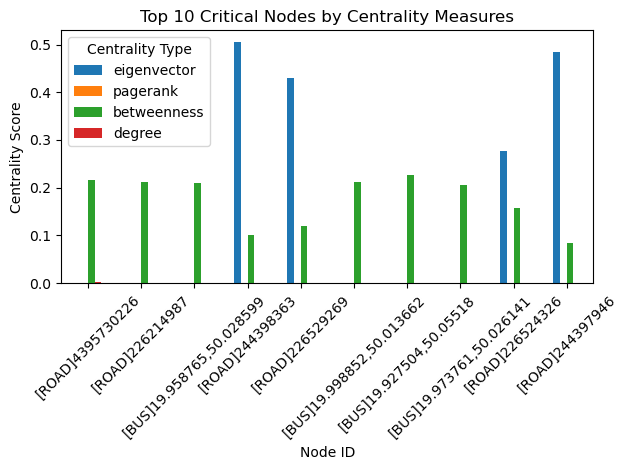


Critical Node Types:
type
Road Intersection    6
Bus Stop             4
Name: count, dtype: int64

Top Critical Nodes:
                           eigenvector  pagerank  betweenness    degree  \
[ROAD]4395730226          1.294847e-09  0.000367     0.215726  0.001817   
[ROAD]226214987           6.227933e-06  0.000256     0.212161  0.001003   
[BUS]19.958765,50.028599  8.004246e-07  0.000222     0.209794  0.001128   
[ROAD]244398363           5.046536e-01  0.000160     0.100319  0.000376   
[ROAD]226529269           4.294034e-01  0.000171     0.118901  0.000376   

                          eigenvector_norm  pagerank_norm  betweenness_norm  \
[ROAD]4395730226              2.565814e-09       0.728896          0.920944   
[ROAD]226214987               1.234100e-05       0.502435          0.905721   
[BUS]19.958765,50.028599      1.586087e-06       0.433659          0.895617   
[ROAD]244398363               1.000000e+00       0.307125          0.428266   
[ROAD]226529269               8.50

In [ ]:
def analyze_critical_nodes(multimodal_centrality, integrated_network):
    """Identify and analyze critical nodes in the multimodal network"""
    # Combine centrality measures
    centrality_df = multimodal_centrality['eigen'].rename(columns={'eigen': 'eigenvector'})
    centrality_df = centrality_df.join(multimodal_centrality['pagerank'])
    centrality_df = centrality_df.join(multimodal_centrality['betweenness'])
    centrality_df = centrality_df.join(multimodal_centrality['degree'])
    
    # Normalize centrality scores
    for col in centrality_df.columns:
        centrality_df[f'{col}_norm'] = (
            centrality_df[col] - centrality_df[col].min()
        ) / (centrality_df[col].max() - centrality_df[col].min())
    
    # Create composite score
    centrality_df['composite_score'] = centrality_df[[f'{col}_norm' for col in centrality_df.columns[:4]]].mean(axis=1)
    
    # Get top 10 critical nodes
    critical_nodes = centrality_df.sort_values('composite_score', ascending=False).head(10)
    
    # Visualize
    plt.figure(figsize=(12, 8))
    critical_nodes[['eigenvector', 'pagerank', 'betweenness', 'degree']].plot(kind='bar')
    plt.title('Top 10 Critical Nodes by Centrality Measures')
    plt.ylabel('Centrality Score')
    plt.xlabel('Node ID')
    plt.xticks(rotation=45)
    plt.legend(title='Centrality Type')
    plt.tight_layout()
    plt.show()
    
    # Analyze node types
    node_types = []
    for node in critical_nodes.index:
        if '[ROAD]' in node:
            node_types.append('Road Intersection')
        elif '[BUS]' in node:
            node_types.append('Bus Stop')
        else:
            node_types.append('Unknown')
    
    critical_nodes['type'] = node_types
    
    # Print insights
    print("\nCritical Node Types:")
    print(critical_nodes['type'].value_counts())
    
    print("\nTop Critical Nodes:")
    print(critical_nodes.head())
    
    return critical_nodes

# Analyze critical nodes
critical_nodes = analyze_critical_nodes(multimodal_centrality, integrated_network)

In [216]:
import plotly.graph_objects as go

def visualize_critical_nodes_on_map(critical_nodes, integrated_network, filename='10_critical_nodes_map.html'):
    m = folium.Map(location=[50.0614, 19.9372], zoom_start=12, tiles='CartoDB positron')
    color_map = {'Road Intersection': 'blue', 'Bus Stop': 'red', 'Unknown': 'gray'}
    for idx, row in critical_nodes.iterrows():
        node = idx
        data = integrated_network.nodes[node]
        folium.CircleMarker(
            location=[data['y'], data['x']],
            radius=12,
            color=color_map.get(row['type'], 'gray'),
            fill=True,
            fill_opacity=0.8,
            popup=folium.Popup(
                f"<b>{row['type']}</b><br>ID: {node}<br>"
                f"Composite Score: {row['composite_score']:.3f}<br>"
                f"Eigenvector: {row['eigenvector']:.3g}<br>"
                f"PageRank: {row['pagerank']:.3g}<br>"
                f"Betweenness: {row['betweenness']:.3g}<br>"
                f"Degree: {row['degree']:.3g}<br>"
                f"Mean Edge Betweenness: {row['mean_edge_betweenness']:.3g}",
                max_width=350
            )
        ).add_to(m)
    m.save(filename)
    print(f"Critical nodes map saved as {filename}")

def save_critical_nodes_plot(critical_nodes, filename='10_critical_nodes_plot.html'):
    fig = go.Figure()
    for col in ['eigenvector', 'pagerank', 'betweenness', 'degree', 'mean_edge_betweenness']:
        fig.add_trace(go.Bar(
            x=critical_nodes.index.astype(str),
            y=critical_nodes[col],
            name=col.replace('_', ' ').title()
        ))
    fig.update_layout(
        barmode='group',
        title='Top 10 Critical Nodes by Centrality Measures (including Edge Betweenness)',
        xaxis_title='Node ID',
        yaxis_title='Centrality Score',
        legend_title='Centrality Type',
        height=600
    )
    fig.write_html(filename)
    print(f"Critical nodes plot saved as {filename}")

# Usage:
visualize_critical_nodes_on_map(critical_nodes, integrated_network, filename= os.path.join(MERGED_DIR, '10_critical_nodes_map.html'))
save_critical_nodes_plot(critical_nodes, filename=os.path.join(MERGED_DIR, '10_critical_nodes_plot.html'))

Critical nodes map saved as results/merged_gtfs_osm/10_critical_nodes_map.html
Critical nodes plot saved as results/merged_gtfs_osm/10_critical_nodes_plot.html
